# Explore Census data
after importing voter info (SoE) and Census data (geolocation)  
slice and dice data to explore what interesting relationships exist

In [1]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

In [2]:
host = 'localhost'
port = 5432
db = 'geocoder'
engine = create_engine(f'postgresql://sean:pass1234@{host}:{port}/{db}')

## Gather various dataframes for display/analysis
* gdf=geopandas dataframe
* hd16 = housedistrict 16 in Duval County Florida
* tiger db-schema is populated by [PostGis](https://postgis.net/) scripts, loading from [US Census](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html)
* This proof of concept notebook is focused on the Southwest section of House District 16 _(e.g. gdf_swhd16*)_ 
* 

In [102]:

sql = "SELECT * from house_districts where namelsad like 'State House District 16';"

# Load the data into a GeoDataFrame
gdf_hd16 = gpd.read_postgis(sql, con=engine, geom_col='geom').to_crs(epsg=3857)
gdf_hd16['centroid'] = gdf_hd16['geom'].centroid
gdf_hd16

,gid,statefp,sldlst,geoid,geoidfq,namelsad,lsad,lsy,mtfcc,funcstat,aland,awater,intptlat,intptlon,geom,centroid
0,57,12,016,12016,620L800US12016,State House District 16,LL,2022,G5220,N,175877333.0,125775021.0,+30.3304459,-081.4348323,"MULTIPOLYGON (((-9079130.617 3540485.08, -9079...",POINT (-9065015.809 3545952.115)


In [108]:
sql = "select * from tiger.tract"
gdf_tracts = gpd.read_postgis(sql, con=engine, geom_col='the_geom').to_crs(epsg=3857)
gdf_tracts['centroid'] = gdf_tracts['the_geom'].centroid
gdf_tracts_hd16 = gpd.sjoin(gdf_tracts, gdf_hd16, how='inner')
gdf_tracts_hd16['centroid'] = gdf_tracts_hd16['the_geom'].centroid
print(f"All tracts count({len(gdf_tracts)}) ==> hd16 count:{len(gdf_tracts_hd16)}")

All tracts count(5160) ==> hd16 count:48


*NOTE:* the tracts and blockgroups below are semi-arbitrary. They were chosen as a smallish test area for canvasing. 

In [159]:
from sqlalchemy import text
# All tracts count(5160) ==> swhd16 tracts count:29 -- swhd16 blockgroups:6
# SQL query to get census tracts within House District 16
sql = text("""
SELECT bg.the_geom, bg.tractce, bg.blkgrpce, concat(bg.tractce,'-',bg.blkgrpce) as label, bg.the_geom as geom
FROM tiger.bg bg
WHERE 
    bg.statefp='12' AND bg.countyfp = '031'AND 
    (
    (bg.tractce like '014311' AND (bg.blkgrpce like '1%' OR bg.blkgrpce like '2%' or bg.blkgrpce like '3%')) OR 
    (bg.tractce = '014500' AND (bg.blkgrpce like '1%' OR bg.blkgrpce like '2%' OR bg.blkgrpce like '3%'))  OR
    (bg.tractce like '014604')  
    )
;
""")

# Load the data into a GeoDataFrame
gdf_bg_swhd16 = gpd.read_postgis(sql, con=engine, geom_col='geom').to_crs(epsg=3857)
gdf_bg_swhd16['centroid'] = gdf_bg_swhd16['geom'].centroid

gdf_tracts_swhd16 = gpd.sjoin(gdf_tracts, gdf_bg_swhd16, how='inner')
gdf_tracts_swhd16['centroid'] = gdf_tracts_swhd16['the_geom'].centroid
print(f"All tracts count({len(gdf_tracts)}) ==> swhd16 tracts count:{len(gdf_tracts_swhd16)} -- swhd16 blockgroups:{len(gdf_bg_swhd16)}")
# gdf

All tracts count(5160) ==> swhd16 tracts count:41 -- swhd16 blockgroups:9


In [160]:
# query = "select id, name, address, type, closings, nonprofit"
query = "select * from schools"
# Reproject GeoDataFrame to EPSG:3857 for compatibility with basemaps
gdf_schools_all = gpd.read_postgis(query, con=engine, geom_col='geom').to_crs(epsg=3857)

gdf_schools_hd16 = gpd.sjoin(gdf_schools_all, gdf_hd16, how='inner')     # , op='intersects' deprecated, use predicate
gdf_schools_swhd16 = gpd.sjoin(gdf_schools_all, gdf_bg_swhd16, how='inner')     # , op='intersects' deprecated, use predicate
# Calculate centroids for labeling
# gdf_schools_swhd16['centroid'] = gdf_schools_swhd16.geom.centroid
# gdf['geoid'] = gdf.the_geom.geoid
print(f"All schools count({len(gdf_schools_all)}) ==> HD16 schools count:{len(gdf_schools_hd16)} ==> SWHD16 schools count:{len(gdf_schools_swhd16)}")

All schools count(355) ==> HD16 schools count:46 ==> SWHD16 schools count:7


In [161]:
# SQL query
query = " select * from vw_dropped_voters where house_district = 16 ;"

# Load into a DataFrame
# df = pd.read_sql(query, engine)
gdf_dropped_hd16 = gpd.read_postgis(query, con=engine, geom_col='geom')
gdf_dropped_hd16 = gdf_dropped_hd16.to_crs(epsg=3857)
# gdf_dropped_hd16['centroid'] = gdf_dropped_hd16.geom.centroid
# gdf_dropped_hd16 
gdf_dropped_swhd16 = gpd.sjoin(gdf_dropped_hd16, gdf_bg_swhd16, how='inner')
# gdf_dropped_sw
print(f"HD 16 DROPPED voter count:({len(gdf_dropped_hd16)}) ==> SWHD16 dropped voter count:{len(gdf_dropped_swhd16)} ")


HD 16 DROPPED voter count:(214) ==> SWHD16 dropped voter count:8 


## Full HD 16
Start with an overview of HD16 in full,  
then later drill into the smaller set of 6 blockgroups.

/tmp/ipykernel_2092024/1743044120.py:36: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


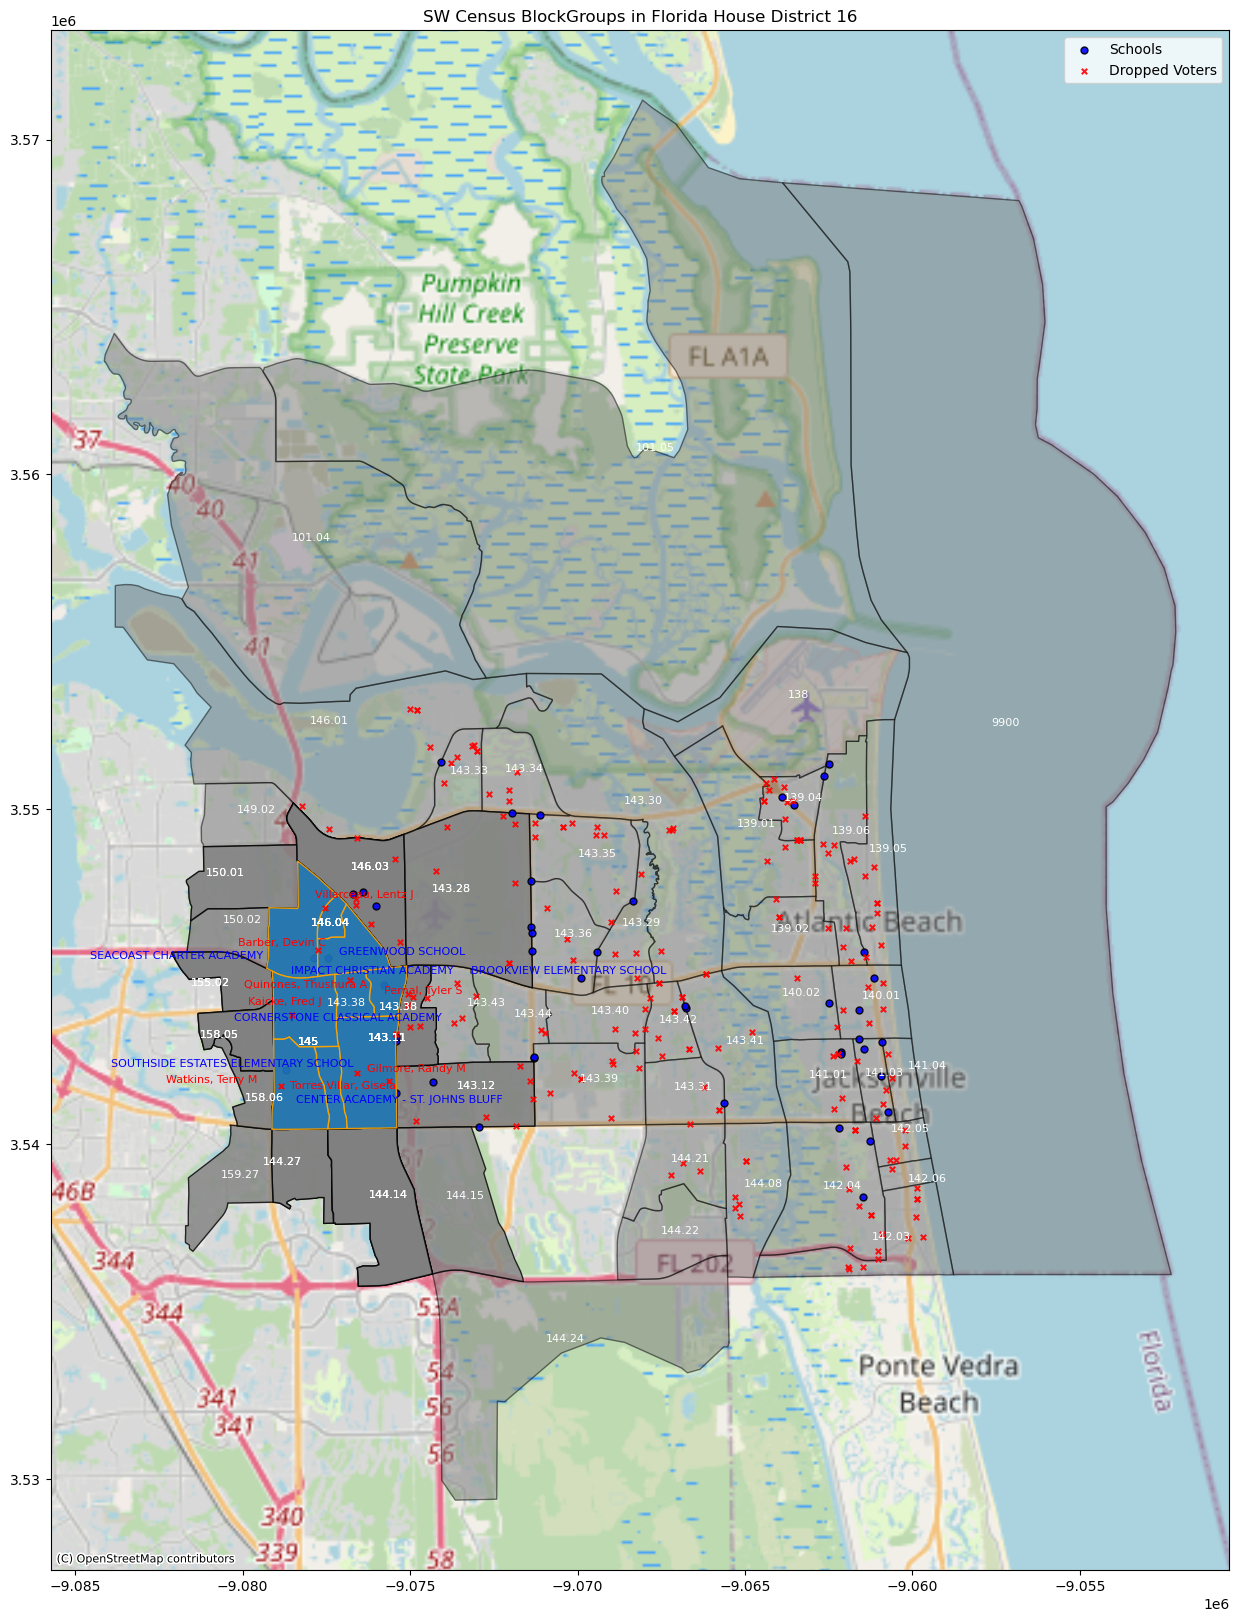

In [162]:
from adjustText import adjust_text

texts = []
fig, ax = plt.subplots(figsize=(20, 20))
ax_1 = gdf_tracts_hd16.plot(ax=ax, figsize=(10, 10), alpha=0.5, color='gray', edgecolor='k', label='Tracts')      # , label='HD 16 Tracts'    # UserWarning: Legend does not support handles for PatchCollection instances.
for idx, row in gdf_tracts_hd16.iterrows():
    texts.append(plt.text(row['centroid'].x, row['centroid'].y, row['name'], fontsize=8, ha='center', color='white'))

ax_sw = gdf_tracts_swhd16.plot(ax=ax, alpha=0.8, color='gray', edgecolor='k')      # , label='HD 16 Tracts'    # UserWarning: Legend does not support handles for PatchCollection instances.
for idx, row in gdf_tracts_swhd16.iterrows():
    texts.append(plt.text(row['centroid'].x, row['centroid'].y, row['name'], fontsize=8, ha='center', color='white'))


ax_2 = gdf_schools_hd16.plot(ax=ax, alpha=0.9, edgecolor='k', color='blue', marker='o', markersize=25, label='Schools')
ctx.add_basemap(ax, crs=gdf_bg_swhd16.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
for idx, row in gdf_schools_swhd16.iterrows():
    texts.append(plt.text(row['geom'].x, row['geom'].y, row['name'], fontsize=8, ha='center', color='blue'))


ax_bg = gdf_bg_swhd16.plot(ax=ax, alpha=0.9, edgecolor='orange', label='SW HD16 BG')
ctx.add_basemap(ax, crs=gdf_bg_swhd16.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
# for idx, row in gdf_bg_swhd16.iterrows():
#     texts.append(plt.text(row['geom'].x, row['geom'].y, row['voter_name'], fontsize=8, ha='center', color='green'))

ax_3 = gdf_dropped_hd16.plot(ax=ax, alpha=0.9, color='red', marker='x', markersize=15, label='Dropped Voters')
ctx.add_basemap(ax, crs=gdf_bg_swhd16.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
for idx, row in gdf_dropped_swhd16.iterrows():
    texts.append(plt.text(row['geom'].x, row['geom'].y, row['voter_name'], fontsize=8, ha='center', color='red'))

# Adjust text positions to avoid overlap
adjust_text(texts)
# gdf_tracts_hd16
# Add a title
plt.title('SW Census BlockGroups in Florida House District 16')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend()

# Show the plot
plt.show()

## Focused Blockgroups for "SW" HD16
After the 'big picture', now drill into canvasing test-run blockgroups... 

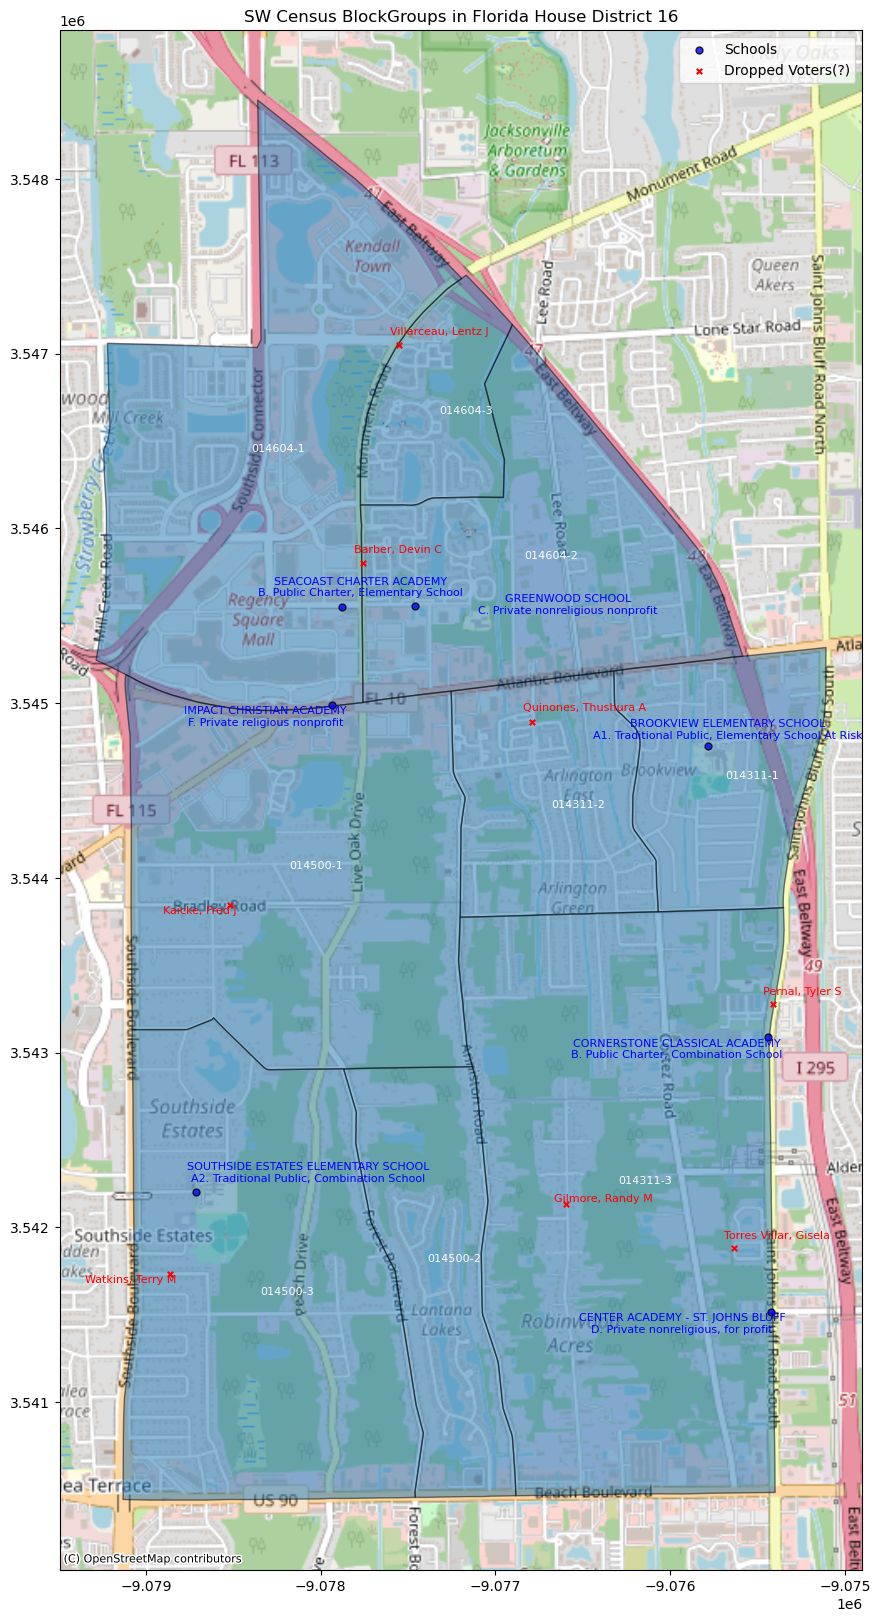

In [164]:
from adjustText import adjust_text

texts = []
# Reproject to EPSG:3857 for compatibility with basemaps
# gdf_swhd16 = gdf_swhd16.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(20, 20))
ax_1 = gdf_bg_swhd16.plot(ax=ax, figsize=(10, 10), alpha=0.5, edgecolor='k')
# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
for idx, row in gdf_bg_swhd16.iterrows():
    texts.append(plt.text(row['centroid'].x, row['centroid'].y, row['label'], fontsize=8, ha='center', color='white'))

ax_2 = gdf_schools_swhd16.plot(ax=ax, alpha=0.8, edgecolor='k', color='blue', marker='o', markersize=25, label='Schools')
ctx.add_basemap(ax, crs=gdf_bg_swhd16.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
for idx, row in gdf_schools_swhd16.iterrows():
    texts.append(plt.text(row['geom'].x, row['geom'].y, f"{row['name']}\n{row['type']}" , fontsize=8, ha='center', color='blue'))


ax_3 = gdf_dropped_swhd16.plot(ax=ax, color='red', marker='x', markersize=15, label='Dropped Voters(?)')
ctx.add_basemap(ax, crs=gdf_bg_swhd16.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
for idx, row in gdf_dropped_swhd16.iterrows():
    texts.append(plt.text(row['geom'].x, row['geom'].y, row['voter_name'], fontsize=8, ha='center', color='red'))

# Adjust text positions to avoid overlap
adjust_text(texts)

# Add a title
plt.title('SW Census BlockGroups in Florida House District 16')
plt.legend()

# Show the plot
plt.show()
